# Numerical Solution for the Newtonian Model at Order One Times

## Import the Necessary Libraries and Define Functions

In [1]:
# Import the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import erf
from scipy.special import erfc

# Use LaTeX font for plots.
plt.rcParams['text.usetex'] = True

In [2]:
# Define the system of ODEs.
def semidiscODEs(h,t, N,dx):
    
    # Compute h_0 using the boundary condition.
    if t==0:
        h0 = 1
    else:
        # Solve the cubic for h0, which contains h1 and h2.
        # used https://en.wikipedia.org/wiki/Cubic_equation#General_cubic_formula
        
        # Order 2?
        a  = -3
        b  = -2*h[0] - h[1]
        c  = 5*h[0]**2 - 2*h[0]*h[1]
        d  = 4*h[0]**3 - h[1]*(h[0]**2) + 8*dx
        D0 = b**2 - 3*a*c
        D1 = 2*b**3 - 9*a*b*c +27*d*(a**2)
        C  = np.cbrt((D1+np.sqrt(D1**2 - 4*D0**3))/2)
        h0 = -(b + C + D0/C)/(3*a)
     
    # Give h_N.
    hN = 1
    
    # Write vectors of h, one with h_0, one with h_N.
    hl = np.concatenate((np.array([h0]),h))
    hu = np.concatenate((h,np.array([hN])))
    
    # Compute the respective fluxes.
    q = (((hu+hl)/2)**3)*(hu-hl)/dx + (hu+hl)/2
    
    # Compute dh_i/dt for each i
    dh = (q[1:]-q[:-1])/dx
    
    return dh

In [3]:
# Find the value of h_0 given the end result.
def h0(h,t, dx):
    # Solve the cubic for h0, which contains h1 and h2.
    # used https://en.wikipedia.org/wiki/Cubic_equation#General_cubic_formula
    
    # Order 1?
    #D0 = 4*h[:,0]**2
    #D1 = 16*h[:,0]**3+108*dx
    #C  = np.cbrt((-D1+np.sqrt(D1**2-4*D0**3))/2)
    #h0 = -(h[:,0] + C + D0/C)/3
    
    # Order 2?
    a  = -3
    b  = -2*h[:,0] - h[:,1]
    c  = 5*h[:,0]**2 - 2*h[:,0]*h[:,1]
    d  = 4*h[:,0]**3 - h[:,1]*(h[:,0]**2) + 8*dx
    D0 = b**2 - 3*a*c
    D1 = 2*b**3 - 9*a*b*c + 27*d*(a**2)
    C  = np.cbrt((D1+np.sqrt(D1**2 - 4*D0**3))/2)
    h0 = -(b + C + D0/C)/(3*a)
    
    h0[0] = 1
    
    return np.array([h0]).T

In [4]:
# Function that computes the L2 error in the solution at each time.
def L2error(num, an, N):
    d = (an-num)**2
    c = np.sqrt(np.sum(d, axis=1)/(N+1))
    return c

In [5]:
# Function that computes the experimental order of convergence.
def EOCs(N,err):
    EOCs = np.zeros(len(err)-1)
    for i in range(len(EOCs)):
        EOCs[i] = np.log(err[i+1]/err[i])/np.log(N[i]/N[i+1])
    return EOCs

## Import the Necessary Libraries and Define Functions

In [6]:
# Define the parameters of the system, the time array, and the space grid.
N = 2**8
XN = 50
dx = XN/N
t = np.arange(0,51,0.5)
y_init0 = np.zeros(N-1)
y_init1 = np.ones(N-1)
x = np.linspace(0,XN,N+1)

#Set up a meshgrid of x and t for the analytical solution.
x2, t2 = np.meshgrid(x, t)

## Solve the IVP

In [7]:
# Solve the IVP. # Uses faster version
y = odeint(semidiscODEs, y_init1, t, args=(N,dx))

# Use the boundary value to find the value at x_N
yN = np.array([np.ones(len(t))]).T

# Glue x_0, x_N parts to the rest of the solution.
y_num = np.concatenate((h0(y,t2,dx),y,yN), axis=1)

## Plot the Interface Heights

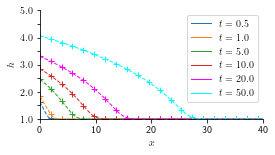

In [8]:
# Pick some time points to plot.
t_arr = np.array([0.5, 1, 5, 10, 20, 50])

# Set up the plot.
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'magenta', 'cyan']

# Plot for a few different times.
for i in range(len(t_arr)):
    # Find the index for the specified time
    t_index = int(np.round(t_arr[i]/0.5))
    
    # Do the plotting.
    ax.plot(x, y_num[t_index,:], '--' , marker='+', markevery=10, linewidth=1, color=cols[i])
    ax.plot([0,1],[10,10], color=cols[i], linewidth=1, label=r'$t=s1$'.replace('s1',str(t_arr[i])))

    
#Add details to the plot.
ticks1 = np.arange(0,50,10)
ax.set_xticks(ticks1, labels=np.round(ticks1,1))
ax.set_xlim(0,40)
ax.set_xlabel(r'$x$')
xticks = ax.xaxis.get_major_ticks()


ticks2 = np.arange(1,5.5,0.5)
ax.set_yticks(ticks2)
ax.set_ylim(1,5)
ax.set_ylabel(r'$h$')
yticks = ax.yaxis.get_major_ticks()
for i in range(len(ticks2)):
    yticks[i].label1.set_visible((i+1)%2)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.legend()
#plt.savefig('Newt_OrderOneT_NumAn2', bbox_inches='tight', dpi=500)
plt.show()

## Solve the IVP for a larger $N$

In [9]:
# Find highest N approximation in reasonable time frame.
N3 = 2**12
dx3 = XN/N3


y_init13 = np.ones(N3-1)
t3 = np.arange(0,51,0.5)
x3 = np.linspace(0,XN,N3+1)
np.arange(0,51,0.5)
#Set up a meshgrid of x and t for the analytical solution.
x4, t4 = np.meshgrid(x3, t3)

In [10]:
# Solve the IVP. # Uses faster version
y3 = odeint(semidiscODEs, y_init13, t3, args=(N3,dx3))

# Use the boundary value to find the value at x_N
yN3 = np.array([np.ones(len(t3))]).T

# Glue x_0, x_N parts to the rest of the solution.
y_num3 = np.concatenate((h0(y3,t4,dx3),y3,yN3), axis=1)

## Compute the $L_2$ Difference for a Several $N$ and Plot this Against Step Size

In [11]:
Nexps = np. arange(5,12,1)
N_arr = 2**Nexps

L2err_arr = np.zeros(len(N_arr))
L2err_arr2= np.zeros(len(N_arr))

for i in range(len(N_arr)):
    #Find the numerical solution for different N.
    N = N_arr[i]
    dx = XN/N
    x = np.linspace(0,XN,N+1)
    y_init = np.ones(N-1)
    
    #Set up a meshgrid of x and t for the analytical solution.
    x2, t2 = np.meshgrid(x, t)
    
    # Solve the IVP and append x_0, x_N.
    y2 = odeint(semidiscODEs, y_init, t, args=(N,dx))
    y_num2 = np.concatenate((h0(y2,t2,dx),y2,yN), axis=1)

    # Compute the L2 error.
    L2err = L2error(y_num2, y_num3[:,::2**(12-Nexps[i])], N+1)
    
    # Put the largest L2 error into an array.
    L2err_arr[i] = max(L2err)
    L2err_arr2[i]= np.sqrt(np.sum(L2err**2)/len(t))

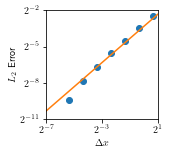

In [12]:
# Compute EOCs for L2 error over x and t.
EOC_arr2 = EOCs(N_arr, L2err_arr2)
#print(EOC_arr2)

# Array to plot a line of gradient 2 to go through the points.
q = np.linspace(0,2,20001)

# Set up the figure.
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)

# Plot step size against L2 error over x and t.
ax.plot(q,0.1*q**1, color='tab:orange')
ax.scatter(XN/N_arr, L2err_arr2)

# Add details to the plot.
ax.set_xlim(2**(-7),2**(1))
ax.set_xticks(1/(2**np.arange(0,6,2)))
ax.set_xscale('log', base=2)
ax.set_xlabel(r'$\Delta x$')

ax.set_ylim(2**(-11),2**(-2))
ax.set_yscale('log', base=2)
ax.set_ylabel(r'$L_2$ Error')

#plt.savefig('Newt_OrderOneT_L2error_xt', bbox_inches='tight', dpi=500)
plt.show()